In [ ]:
!pip install tensorflow matplotlib opencv-python

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_DIR = "/content/drive/My Drive/LandslideDetection/data/train/images"
MASK_DIR = "/content/drive/My Drive/LandslideDetection/data/train/masks"

In [ ]:
IMG_SIZE = 256

In [ ]:
def load_data(img_dir, mask_dir, img_size):
    images = []
    masks = []
    image_filenames = sorted(os.listdir(img_dir))  # Ensure matching order
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_name, mask_name in zip(image_filenames, mask_filenames):
        # Load Image
        img = load_img(os.path.join(img_dir, img_name), target_size=(img_size, img_size))
        img = img_to_array(img) / 255.0  # Normalize

        # Load Mask
        mask = load_img(os.path.join(mask_dir, mask_name), target_size=(img_size, img_size), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0  # Normalize to [0,1]
        mask = np.where(mask > 0.5, 1, 0)  # Thresholding for binary masks

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_data(IMG_DIR, MASK_DIR, IMG_SIZE)

print(f"Loaded {len(X)} images and {len(Y)} masks")

Loaded 1385 images and 1385 masks


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print(f"New y_train shape: {Y_train.shape}")
print(f"New y_val shape: {Y_val.shape}")

New y_train shape: (1108, 256, 256, 1)
New y_val shape: (277, 256, 256, 1)


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)

X_train shape: (1108, 256, 256, 3)
y_train shape: (1108, 256, 256, 1)


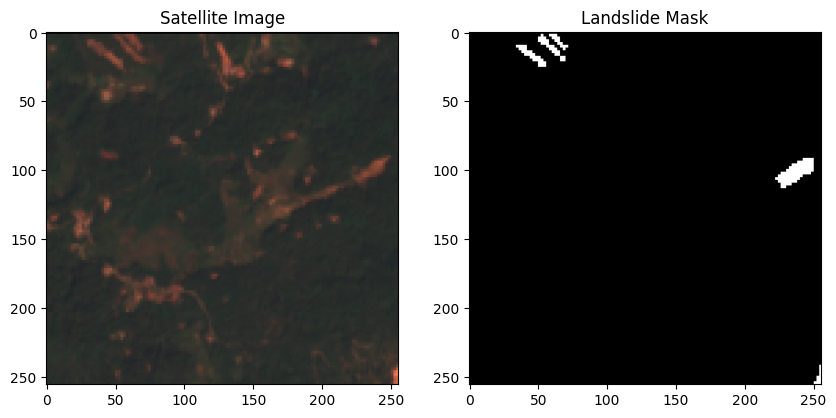

In [ ]:
def visualize_sample(index):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(X_train[index])
    plt.title("Satellite Image")

    plt.subplot(1, 2, 2)
    plt.imshow(Y_train[index].squeeze(), cmap="gray")
    plt.title("Landslide Mask")

    plt.show()

# Show sample
visualize_sample(0)

In [ ]:
import tensorflow as tf

BATCH_SIZE = 8

# Convert arrays to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

# Shuffle and batch
train_dataset = train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int64, name=None))>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Use MobileNetV2 as feature extractor
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=inputs)

    # Feature layers
    high_res_features = base_model.get_layer("block_2_add").output  # Lower-level features
    low_res_features = base_model.get_layer("block_13_expand_relu").output  # High-level features

    # ASPP Block
    conv1x1 = Conv2D(256, (1, 1), padding="same", activation="relu")(low_res_features)
    conv3x3_1 = Conv2D(256, (3, 3), padding="same", dilation_rate=6, activation="relu")(low_res_features)
    conv3x3_2 = Conv2D(256, (3, 3), padding="same", dilation_rate=12, activation="relu")(low_res_features)
    conv3x3_3 = Conv2D(256, (3, 3), padding="same", dilation_rate=18, activation="relu")(low_res_features)

    # Concatenate ASPP outputs
    x = Concatenate()([conv1x1, conv3x3_1, conv3x3_2, conv3x3_3])

    # Reduce channels
    x = Conv2D(256, (1, 1), padding="same", activation="relu")(x)

    # Upsampling
    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Concatenate with high-resolution features
    x = Concatenate()([x, high_res_features])
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # Final upsampling
    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = Conv2D(num_classes, (1, 1), activation="sigmoid")(x)

    return Model(inputs=inputs, outputs=x)

# Initialize Model
model = DeeplabV3Plus()
from tensorflow.keras.optimizers import Adam
# Compile Model
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#optimizer = Adam(learning_rate=0.0001)  # Reduce from default 0.001 to 0.0001

#model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
import tensorflow.keras.backend as K
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, dtype='float32')  # Ensure same dtype
    y_pred = K.cast(y_pred, dtype='float32')

    y_pred = K.round(y_pred)  # Convert probabilities to binary (0 or 1)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_loss(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return 1 - (intersection + smooth) / (union + smooth)  # IoU loss

model.compile(optimizer="adam", loss=iou_loss, metrics=["accuracy", iou_metric])

# Summary
model.summary()


<ipython-input-13-d7731b66886f>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=inputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 5,331,777 (20.34 MB)

 Trainable params: 5,314,241 (20.27 MB)

 Non-trainable params: 17,536 (68.50 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.5, patience=3, verbose=1, mode="max")
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)

In [ ]:
EPOCHS = 22  # Train for 22 epochs

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint, reduce_lr]  # Removed early_stop
)

Epoch 1/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - iou: 0.3743 - loss: 0.0708
Epoch 1: val_loss improved from inf to 0.15148, saving model to best_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 277ms/step - iou: 0.3743 - loss: 0.0708 - val_iou: 0.1007 - val_loss: 0.1515 - learning_rate: 0.0010
Epoch 2/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - iou: 0.4090 - loss: 0.0633
Epoch 2: val_loss improved from 0.15148 to 0.13108, saving model to best_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - iou: 0.4090 - loss: 0.0633 - val_iou: 0.1760 - val_loss: 0.1311 - learning_rate: 0.0010
Epoch 3/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - iou: 0.4131 - loss: 0.0600
Epoch 3: val_loss did not improve from 0.13108
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - iou: 0.4131 - loss: 0.0601 - val_iou: 0.0869 - val_loss: 0.1545 - learning_rate: 0.0010
Epoch 4/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - iou: 0.4316 - loss: 0.0566
Epoch 4: val_loss did not improve from 0.13108
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - iou: 0.4317 - loss: 0.0566 - val_iou: 0.1184 - val_loss: 0.1551 - learning_rate: 0.0010
Epoch 5/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - iou: 0.4487 - loss: 0.0568
Epoch 5: val_loss did not improve from 0.13108

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - iou: 0.4487 - loss: 0.0568 - val_iou: 0.1218 - val_loss: 0.1350 - learning_rate: 0.00

139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - iou: 0.4759 - loss: 0.0515 - val_iou: 0.2071 - val_loss: 0.1034 - learning_rate: 5.0000e-04
Epoch 7/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - iou: 0.5036 - loss: 0.0486
Epoch 7: val_loss improved from 0.10344 to 0.09408, saving model to best_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - iou: 0.5036 - loss: 0.0486 - val_iou: 0.2476 - val_loss: 0.0941 - learning_rate: 5.0000e-04
Epoch 8/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - iou: 0.5225 - loss: 0.0470
Epoch 8: val_loss did not improve from 0.09408
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - iou: 0.5224 - loss: 0.0470 - val_iou: 0.1802 - val_loss: 0.1227 - learning_rate: 5.0000e-04
Epoch 9/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - iou: 0.5255 - loss: 0.0439
Epoch 9: val_loss did not improve from 0.09408
139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - iou: 0.5255 - loss: 0.0439 - val_iou: 0.1780 - val_loss: 0.1358 - learning_rate: 5.0000e-04
Epoch 10/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - iou: 0.5370 - loss: 0.0429
Epoch 10: val_loss did not improve from 0.09408

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - iou: 0.5370 - loss: 0.0429 - val_iou: 0.2579 - val_loss: 0.1039 - lear


Epoch 19: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - iou: 0.6113 - loss: 0.0330 - val_iou: 0.3722 - val_loss: 0.0941 - learning_rate: 6.2500e-05
Epoch 20/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - iou: 0.6122 - loss: 0.0348
Epoch 20: val_loss improved from 0.09406 to 0.09188, saving model to best_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - iou: 0.6123 - loss: 0.0348 - val_iou: 0.3841 - val_loss: 0.0919 - learning_rate: 3.1250e-05
Epoch 21/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - iou: 0.6239 - loss: 0.0338
Epoch 21: val_loss did not improve from 0.09188
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - iou: 0.6239 - loss: 0.0338 - val_iou: 0.3836 - val_loss: 0.0921 - learning_rate: 3.1250e-05
Epoch 22/22
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - iou: 0.6204 - loss: 0.0331
Epoch 22: val_loss improved from 0.09188 to 0.08857, saving model to best_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - iou: 0.6204 - loss: 0.0331 - val_iou: 0.3995 - val_loss: 0.0886 - learning_rate: 3.1250e-05


In [ ]:
EPOCHS = 30

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

Epoch 1/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - iou: 0.3759 - loss: 0.2062
Epoch 1: val_loss improved from inf to 0.23792, saving model to best_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - iou: 0.3758 - loss: 0.2056 - val_iou: 0.0274 - val_loss: 0.2379 - learning_rate: 0.0010
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - iou: 0.3964 - loss: 0.0667
Epoch 2: val_loss improved from 0.23792 to 0.14078, saving model to best_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - iou: 0.3964 - loss: 0.0667 - val_iou: 0.0941 - val_loss: 0.1408 - learning_rate: 0.0010
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - iou: 0.4128 - loss: 0.0654
Epoch 3: val_loss did not improve from 0.14078
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - iou: 0.4127 - loss: 0.0654 - val_iou: 0.1173 - val_loss: 0.1807 - learning_rate: 0.0010
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - iou: 0.4214 - loss: 0.0634
Epoch 4: val_loss did not improve from 0.14078
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - iou: 0.4215 - loss: 0.0634 - val_iou: 0.0165 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 5/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - iou: 0.4230 - loss: 0.0607
Epoch 5: val_loss did not improve from 0.14078
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - iou: 0.4231 - loss: 0.0606 - val_iou: 0.0882 - val_loss: 0.2029 - learning_rate: 0.0010
Epoch 6/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - iou: 0.4467 - loss

In [ ]:
def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Convert to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Convert to float32

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])

In [ ]:
loss, iou_score = model.evaluate(X_val, Y_val, batch_size=8)  # Adjust batch size if needed
print(f"Test Loss: {loss:.4f}")
print(f"Test IoU: {iou_score:.4f}")  # IoU score

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - iou: 0.4106 - loss: 0.0887
Test Loss: 0.0886
Test IoU: 0.3995


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set test image path
TEST_IMAGE_PATH = "/content/drive/MyDrive/LandslideDetection/data/test/images/image_1319.png"

# Load and preprocess the test image
img_size = 256  # Make sure it's the same size used for training
test_img = load_img(TEST_IMAGE_PATH, target_size=(img_size, img_size))
test_img = img_to_array(test_img) / 255.0  # Normalize
test_img = np.expand_dims(test_img, axis=0)  # Add batch dimension

In [ ]:
# Get the predicted mask
pred_mask = model.predict(test_img)[0]  # Remove batch dimension
pred_mask = np.squeeze(pred_mask)  # Remove extra dimension
pred_mask = np.where(pred_mask > 0.5, 1, 0)  # Threshold to get binary mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
# Set corresponding mask path
TEST_MASK_PATH = "/content/drive/MyDrive/LandslideDetection/data/test/masks/mask_1319.png"

# Load and preprocess the actual mask
true_mask = load_img(TEST_MASK_PATH, target_size=(img_size, img_size), color_mode="grayscale")
true_mask = img_to_array(true_mask) / 255.0  # Normalize
true_mask = np.squeeze(true_mask)  # Remove extra dimension

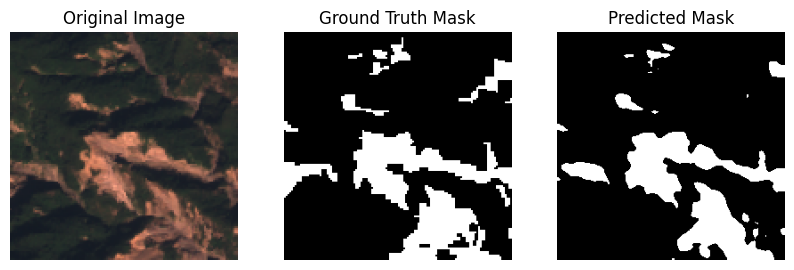

In [ ]:
# Display results
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(test_img[0])  # Original image
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(true_mask, cmap="gray")  # Ground truth mask
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(pred_mask, cmap="gray")  # Predicted mask
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


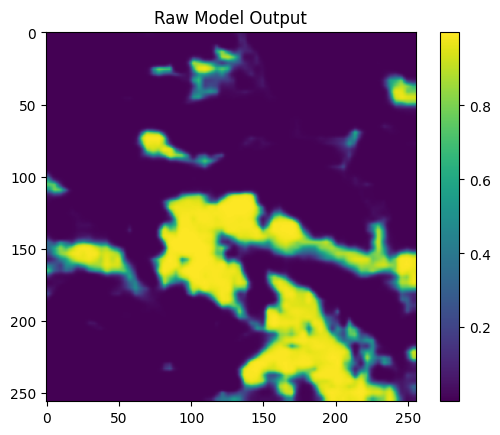

In [ ]:
pred_raw = model.predict(test_img)[0]  # Get raw output
plt.imshow(pred_raw, cmap="viridis")  # Use a color map to see details
plt.colorbar()
plt.title("Raw Model Output")
plt.show()

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/LandslideDetection/model.h5"  # Adjust path if needed

# Save model in HDF5 format
model.save(MODEL_PATH)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


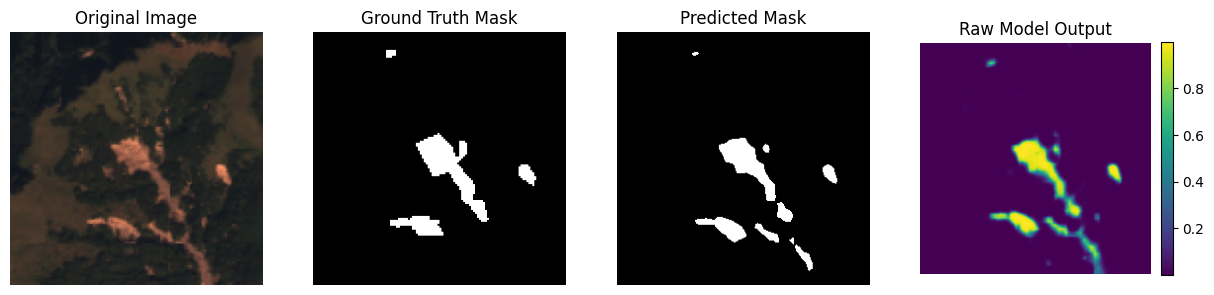

In [ ]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load trained model
MODEL_PATH = "/content/drive/MyDrive/LandslideDetection/model.h5"
model = tf.keras.models.load_model(MODEL_PATH)

# Function to preprocess image and get predictions
def predict_landslide(image_path, model, img_size=256):
    test_img = load_img(image_path, target_size=(img_size, img_size))
    test_img = img_to_array(test_img) / 255.0  # Normalize
    test_img = np.expand_dims(test_img, axis=0)  # Add batch dimension

    pred_raw = model.predict(test_img)[0]  # Get prediction
    pred_mask = np.where(pred_raw > 0.5, 1, 0)  # Convert to binary mask

    results = {"pred_mask": pred_mask.tolist(), "pred_raw": pred_raw.tolist()}  # Store results

    with open("predicted_output.pkl", "wb") as f:
        pickle.dump(results, f)  # Save to file

    return results

# Example usage
image_path = "/content/drive/MyDrive/LandslideDetection/data/validate/images/image_9.png"
results = predict_landslide(image_path, model)

# Load ground truth mask
true_mask_path = "/content/drive/MyDrive/LandslideDetection/data/validate/masks/mask_9.png"
true_mask = load_img(true_mask_path, target_size=(256, 256), color_mode="grayscale")
true_mask = img_to_array(true_mask) / 255.0
true_mask = np.squeeze(true_mask)

# Display images
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

# Ensure correct number of subplots
#if len(axes) != 3:
#    raise ValueError(f"Expected 3 subplots, but got {len(axes)}.")

axes[0].imshow(load_img(image_path))  # Original image
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(true_mask, cmap="gray")  # Ground truth mask
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(np.array(results["pred_mask"]), cmap="gray")  # Predicted mask
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

# Raw Model Output with Color Map
im = axes[3].imshow(np.array(results["pred_raw"]), cmap="viridis")  # Raw output visualization
axes[3].set_title("Raw Model Output")
axes[3].axis("off")
fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)  # Add colorbar for scale

#plt.tight_layout()

plt.show()


In [ ]:
from google.colab import files
files.download("predicted_output.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Landslide Coverage: 27.79%
Grassland (Green Area): 43.33%
Deserted Land (Non-Green Area): 56.67%
Grassland Contribution to Landslide: 35.72%
Deserted Land Contribution to Landslide: 73.29%


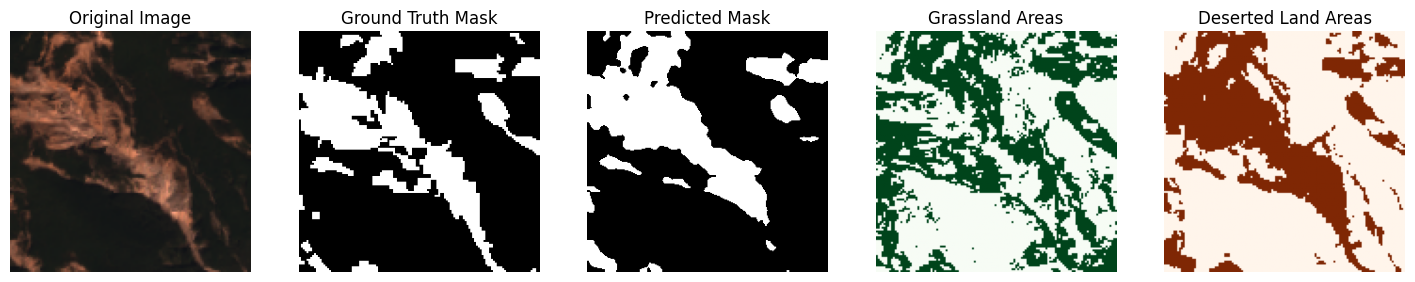

In [ ]:
import numpy as np
import pickle
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load trained model
MODEL_PATH = "/content/drive/MyDrive/LandslideDetection/model.h5"
model = tf.keras.models.load_model(MODEL_PATH)

# Function to preprocess image and get predictions
def predict_landslide(image_path, model, img_size=256):
    test_img = load_img(image_path, target_size=(img_size, img_size))
    test_img = img_to_array(test_img) / 255.0  # Normalize
    test_img = np.expand_dims(test_img, axis=0)  # Add batch dimension

    pred_raw = model.predict(test_img)[0]  # Get prediction
    pred_mask = np.where(pred_raw > 0.5, 1, 0)  # Convert to binary mask

    # Save the predicted mask as an image
    pred_mask_np = (pred_mask * 255).astype(np.uint8)  # Convert 1s to 255 (white)
    predicted_mask_path = "/content/predicted_mask.png"
    cv2.imwrite(predicted_mask_path, pred_mask_np)

    results = {
        "pred_mask": pred_mask,
        "pred_raw": pred_raw,
        "pred_mask_path": predicted_mask_path
    }

    with open("predicted_output.pkl", "wb") as f:
        pickle.dump(results, f)  # Save to file

    return results, predicted_mask_path

# Function to calculate landslide coverage percentage
def calculate_landslide_coverage(mask):
    total_pixels = mask.size
    landslide_pixels = np.count_nonzero(mask)

    return round((landslide_pixels / total_pixels) * 100, 2)

# Function to calculate grassland and deserted land percentage in original image
def calculate_land_distribution(image_path):
    image = cv2.imread(image_path)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert to HSV color space
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  # Convert to LAB color space

    # Define thresholds for green (grassland)
    lower_green = np.array([25, 40, 20])
    upper_green = np.array([90,255,255])
    green_mask = cv2.inRange(image_lab, lower_green, upper_green)

    # Define thresholds for brown/yellow (deserted land)
    lower_deserted = np.array([5, 40, 40])
    upper_deserted = np.array([40, 255, 255])
    deserted_mask = cv2.inRange(image_hsv, lower_deserted, upper_deserted)

    green_pixels = np.count_nonzero(green_mask)
    deserted_pixels = np.count_nonzero(deserted_mask)
    total_pixels = image.shape[0] * image.shape[1]

    green_percentage = (green_pixels / total_pixels) * 100
    deserted_percentage = 100 - green_percentage

    return round(green_percentage, 2), round(deserted_percentage, 2), green_mask, deserted_mask

# Function to calculate contribution of land types to landslide
def calculate_landslide_contributions(pred_mask, green_mask, deserted_mask):
    # Ensure all masks have the same shape as pred_mask
    green_mask = cv2.resize(green_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    deserted_mask = cv2.resize(deserted_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convert masks to binary (ensure they contain only 0s and 1s)
    green_mask = (green_mask > 0).astype(np.uint8)
    deserted_mask = (deserted_mask > 0).astype(np.uint8)

    green_landslide = np.logical_and(pred_mask, green_mask).sum()
    deserted_landslide = np.logical_and(pred_mask, deserted_mask).sum()
    total_green_pixels = green_mask.sum()
    total_deserted_pixels = deserted_mask.sum()
    total_landslide_pixels = pred_mask.sum()

    green_landslide_percentage = (green_landslide / total_green_pixels) * 100 if total_landslide_pixels > 0 else 0
    deserted_landslide_percentage = (deserted_landslide / total_deserted_pixels) * 100 if total_landslide_pixels > 0 else 0

    return round(green_landslide_percentage, 2), round(deserted_landslide_percentage, 2)

# Example usage
image_path = "/content/drive/MyDrive/LandslideDetection/data/test/images/image_373.png"
results, pred_mask_path = predict_landslide(image_path, model)

# Load ground truth mask
true_mask_path = "/content/drive/MyDrive/LandslideDetection/data/test/masks/mask_373.png"
true_mask = load_img(true_mask_path, target_size=(256, 256), color_mode="grayscale")
true_mask = img_to_array(true_mask) / 255.0
true_mask = np.squeeze(true_mask)

# Load predicted mask
pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)
pred_mask = np.where(pred_mask > 127, 1, 0)  # Convert to binary

# Calculate landslide coverage
landslide_coverage = calculate_landslide_coverage(pred_mask)

# Calculate land distribution (grassland & deserted land)
grassland_percentage, deserted_percentage, green_mask, deserted_mask = calculate_land_distribution(image_path)

# Calculate contribution of land types to landslide
green_landslide_percentage, deserted_landslide_percentage = calculate_landslide_contributions(pred_mask, green_mask, deserted_mask)

# Print results
print(f"Landslide Coverage: {landslide_coverage}%")
print(f"Grassland (Green Area): {grassland_percentage}%")
print(f"Deserted Land (Non-Green Area): {deserted_percentage}%")
print(f"Grassland Contribution to Landslide: {green_landslide_percentage}%")
print(f"Deserted Land Contribution to Landslide: {deserted_landslide_percentage}%")

# Display images
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

axes[0].imshow(load_img(image_path))  # Original image
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(true_mask, cmap="gray")  # Ground truth mask
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(pred_mask, cmap="gray")  # Predicted mask
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

axes[3].imshow(green_mask, cmap="Greens")  # Green mask
axes[3].set_title("Grassland Areas")
axes[3].axis("off")

axes[4].imshow(deserted_mask, cmap="Oranges")  # Deserted land mask
axes[4].set_title("Deserted Land Areas")
axes[4].axis("off")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix:
TN: 58868, FP: 840
FN: 1939, TP: 3889

Metrics:
Accuracy: 0.9576
Precision: 0.8224
Recall: 0.6673
F1 Score: 0.7368


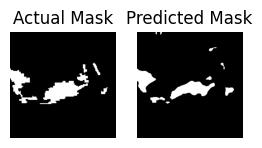

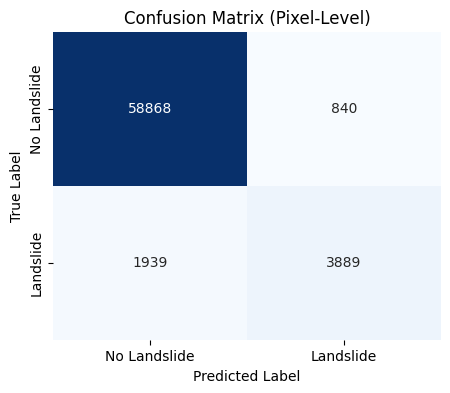

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load Model
model = tf.keras.models.load_model("/content/drive/MyDrive/LandslideDetection/model.h5")

# Define paths
validate_image_path = "/content/drive/MyDrive/LandslideDetection/data/test/images/image_12.png"
validate_mask_path = "/content/drive/MyDrive/LandslideDetection/data/test/masks/mask_12.png"

# Load and preprocess image
img = cv2.imread(validate_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (256, 256)) / 255.0  # Normalize
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Get model prediction
pred_mask = model.predict(img)[0, :, :, 0]  # Remove batch and channel dims
pred_mask = np.where(pred_mask > 0.3, 1, 0).astype(np.uint8)  # Convert to binary mask

# Load and preprocess ground truth mask
gt_mask = cv2.imread(validate_mask_path, cv2.IMREAD_GRAYSCALE)
gt_mask = cv2.resize(gt_mask, (256, 256))
gt_mask = np.where(gt_mask > 127, 1, 0).astype(np.uint8)

# Count the black (0) and white (1) pixels in both actual and predicted masks
black_actual = np.sum(gt_mask == 0)  # Actual black pixels (no landslide)
white_actual = np.sum(gt_mask == 1)  # Actual white pixels (landslide)

black_pred = np.sum(pred_mask == 0)  # Predicted black pixels (no landslide)
white_pred = np.sum(pred_mask == 1)  # Predicted white pixels (landslide)

# Confusion Matrix based on pixel counts
# True Negatives: Black pixels in both actual and predicted (no landslide correctly detected)
TN = np.sum((gt_mask == 0) & (pred_mask == 0))

# True Positives: White pixels in both actual and predicted (landslide correctly detected)
TP = np.sum((gt_mask == 1) & (pred_mask == 1))

# False Positives: Black pixels in actual, but white in predicted (no landslide but predicted as landslide)
FP = np.sum((gt_mask == 0) & (pred_mask == 1))

# False Negatives: White pixels in actual, but black in predicted (landslide but predicted as no landslide)
FN = np.sum((gt_mask == 1) & (pred_mask == 0))

# Compute metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print("Confusion Matrix:")
print(f"TN: {TN}, FP: {FP}")
print(f"FN: {FN}, TP: {TP}")
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Display both predicted and actual masks side by side
plt.figure(figsize=(3, 3))

# Actual mask
plt.subplot(1, 2, 1)
plt.imshow(gt_mask, cmap='gray')
plt.title("Actual Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()
import seaborn as sns
import pandas as pd

# Prepare confusion matrix data
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

labels = ["No Landslide", "Landslide"]

# Create a dataframe for better labeling
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Plot confusion matrix as heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Pixel-Level)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import os

# Load Model
model = tf.keras.models.load_model("/content/drive/MyDrive/LandslideDetection/model.h5")

# Define validation dataset folder paths
image_folder = "/content/drive/MyDrive/LandslideDetection/data/validate/images/"
mask_folder = "/content/drive/MyDrive/LandslideDetection/data/validate/masks/"

# Initialize confusion matrix accumulators
TN_total, FP_total, FN_total, TP_total = 0, 0, 0, 0

# Iterate through all images in the validation dataset
for image_name in os.listdir(image_folder):
    # Define paths for the image and mask
    image_path = os.path.join(image_folder, image_name)
    mask_path = os.path.join(mask_folder, image_name.replace('image', 'mask'))

    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (256, 256)) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Get model prediction
    pred_mask = model.predict(img)[0, :, :, 0]  # Remove batch and channel dims
    pred_mask = np.where(pred_mask > 0.25, 1, 0).astype(np.uint8)  # Convert to binary mask

    # Load and preprocess ground truth mask
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, (256, 256))
    gt_mask = np.where(gt_mask > 127, 1, 0).astype(np.uint8)

    # Calculate confusion matrix values for the current image
    TN = np.sum((gt_mask == 0) & (pred_mask == 0))
    TP = np.sum((gt_mask == 1) & (pred_mask == 1))
    FP = np.sum((gt_mask == 0) & (pred_mask == 1))
    FN = np.sum((gt_mask == 1) & (pred_mask == 0))

    # Accumulate values
    TN_total += TN
    TP_total += TP
    FP_total += FP
    FN_total += FN

# Compute overall metrics
accuracy = (TP_total + TN_total) / (TP_total + TN_total + FP_total + FN_total)
precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
recall = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print("Confusion Matrix (Total):")
print(f"TN: {TN_total}, FP: {FP_total}")
print(f"FN: {FN_total}, TP: {TP_total}")
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━